# Johnson-Cook with 6 strain rates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("mime")
import pandas as pd
import h5py
from scipy.optimize import curve_fit
import lmfit

colors = ['#bb0000', '#00bb00', "#0000bb", '#bbbb00', '#bb00bb', "#00bbbb", '#bbbbbb', '#770000', '#007700', "#000077", '#777700', '#770077', "#007777", '#777777', '#440000', '#004400', "#000044", '#444400', '#440044', "#0044444", '#444444','#000000']

In [2]:
baseSize = (8, 6)  # Base size of a subplot

def sbPlot(n):
    if (n == 1): return 1, 1
    if (n <= 2): return 1, 2
    if (n <= 4): return 2, 2
    if (n <= 6): return 3, 2
    if (n <= 9): return 3, 3
    if (n <= 12): return 4, 3
    return 0, 0

def sbPlotSize(n):
    x, y = sbPlot(n)
    return baseSize[0] * y, baseSize[1] * x

In [3]:
h5f = h5py.File('../GleebleData.h5','r')
allData = h5f['all'][:]
shortData = h5f['short'][:]
h5f.close()

In [4]:
allData.shape, shortData.shape

((21030, 4), (1080, 4))

Remove first point of each curve, where $\varepsilon^p=0$

In [5]:
identData = allData[allData[:,0] != 0]
#identData = shortData[shortData[:,0]!=0]

In [6]:
strains = np.unique(identData[:,0])
allStrains = np.unique(allData[:,0])
epsps = np.unique(identData[:,1])
temperatures = np.unique(identData[:,2])
nEps = len(strains)
nEpsp = len(epsps)
nTemp = len(temperatures)
strains, epsps, temperatures, nEps, nEpsp, nTemp

(array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
        0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
        0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027,
        0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035, 0.036,
        0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044, 0.045,
        0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053, 0.054,
        0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062, 0.063,
        0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07 , 0.071, 0.072,
        0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08 , 0.081,
        0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09 ,
        0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099,
        0.1  , 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108,
        0.109, 0.11 , 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117,
        0.118, 0.119, 0.12 , 0.121, 0.122, 0.123, 0.124, 0.125, 0.126,
      

# Identification of the Johnson-Cook parameters
$\sigma = (A + B\varepsilon^n)\left(1 + C\ln\left(\frac{\dot{\varepsilon^p}}{\dot{\varepsilon^p}}\right)\right)\left(1-\left(\frac{T-T_0}{T_m - T_0}\right)^m\right)$

In [7]:
T0 = temperatures[0]
epsp0 = epsps[0]
Tm = 1460

A is the initial yield at reference strain rate and temperature

In [8]:
A = allData[(allData[:,1]==epsp0) & (allData[:,2]==T0)][0,3]
print("A=%g" %(A))

A=11.7583


Extract the reference curve data

In [9]:
Sig = identData[(identData[:,1]==epsp0) & (identData[:,2]==T0)]
params = np.polyfit(np.log(Sig[:,0]), np.log(Sig[:,3]-A), 1)
n, lnB = params
B = np.exp(lnB)
print("lnB=%g, B=%g, n=%g" %(lnB, B, n))

lnB=3.24116, B=25.5633, n=0.139419


Extract data at reference temperature

In [10]:
sigT0 = identData[identData[:,2]==T0]
sigT0[:,3] = ((sigT0[:,3])/(A + B*(sigT0[:,0])**n)) - 1

In [11]:
def specialFunction(x,s):
    return s*x

S1 = []
cl=0
for epsj in list(strains):
    sbdata = sigT0[sigT0[:,0]==epsj]
    popt, pcov = curve_fit(specialFunction, np.log(sbdata[:,1]/epsp0), sbdata[:,3], bounds=(-np.inf, [np.inf]))
    s = popt
    S1.append(s)
    cl +=1
C  = np.mean(S1)
print("C=%g" %(C))

C=0.33798


In [12]:
sigEpsp0 = identData[(identData[:,1]==epsp0) & (identData[:,2]!=T0)]
sigEpsp0[:,3] = 1 - (sigEpsp0[:,3]/((A + B*(sigEpsp0[:,0])**n)))

In [13]:
J1 = []
cl=0
for epsj in list(strains):
    sbdata = sigEpsp0[sigEpsp0[:,0]==epsj]
    #print(sbdata)
    popt, pcov = curve_fit(specialFunction, np.log((sbdata[:,2]-T0)/(Tm-T0)), np.log(sbdata[:,3]), bounds=(-np.inf, [np.inf]))
    m1 = popt
    J1.append(m1)
    cl +=1
m  = np.mean(J1)
print("m=%g" %(m))

m=0.729783


In [14]:
A,B,C,n,m

(11.75833,
 25.56332405146221,
 0.3379796436973261,
 0.13941929085903132,
 0.7297832897814697)

In [15]:
def JCconstitutiveLaw(eps, epsp, T):
    return (A + B * eps**n) * (1 + C * np.log(epsp / epsp0)) * (1 - ((T - T0) / (Tm - T0))**m)

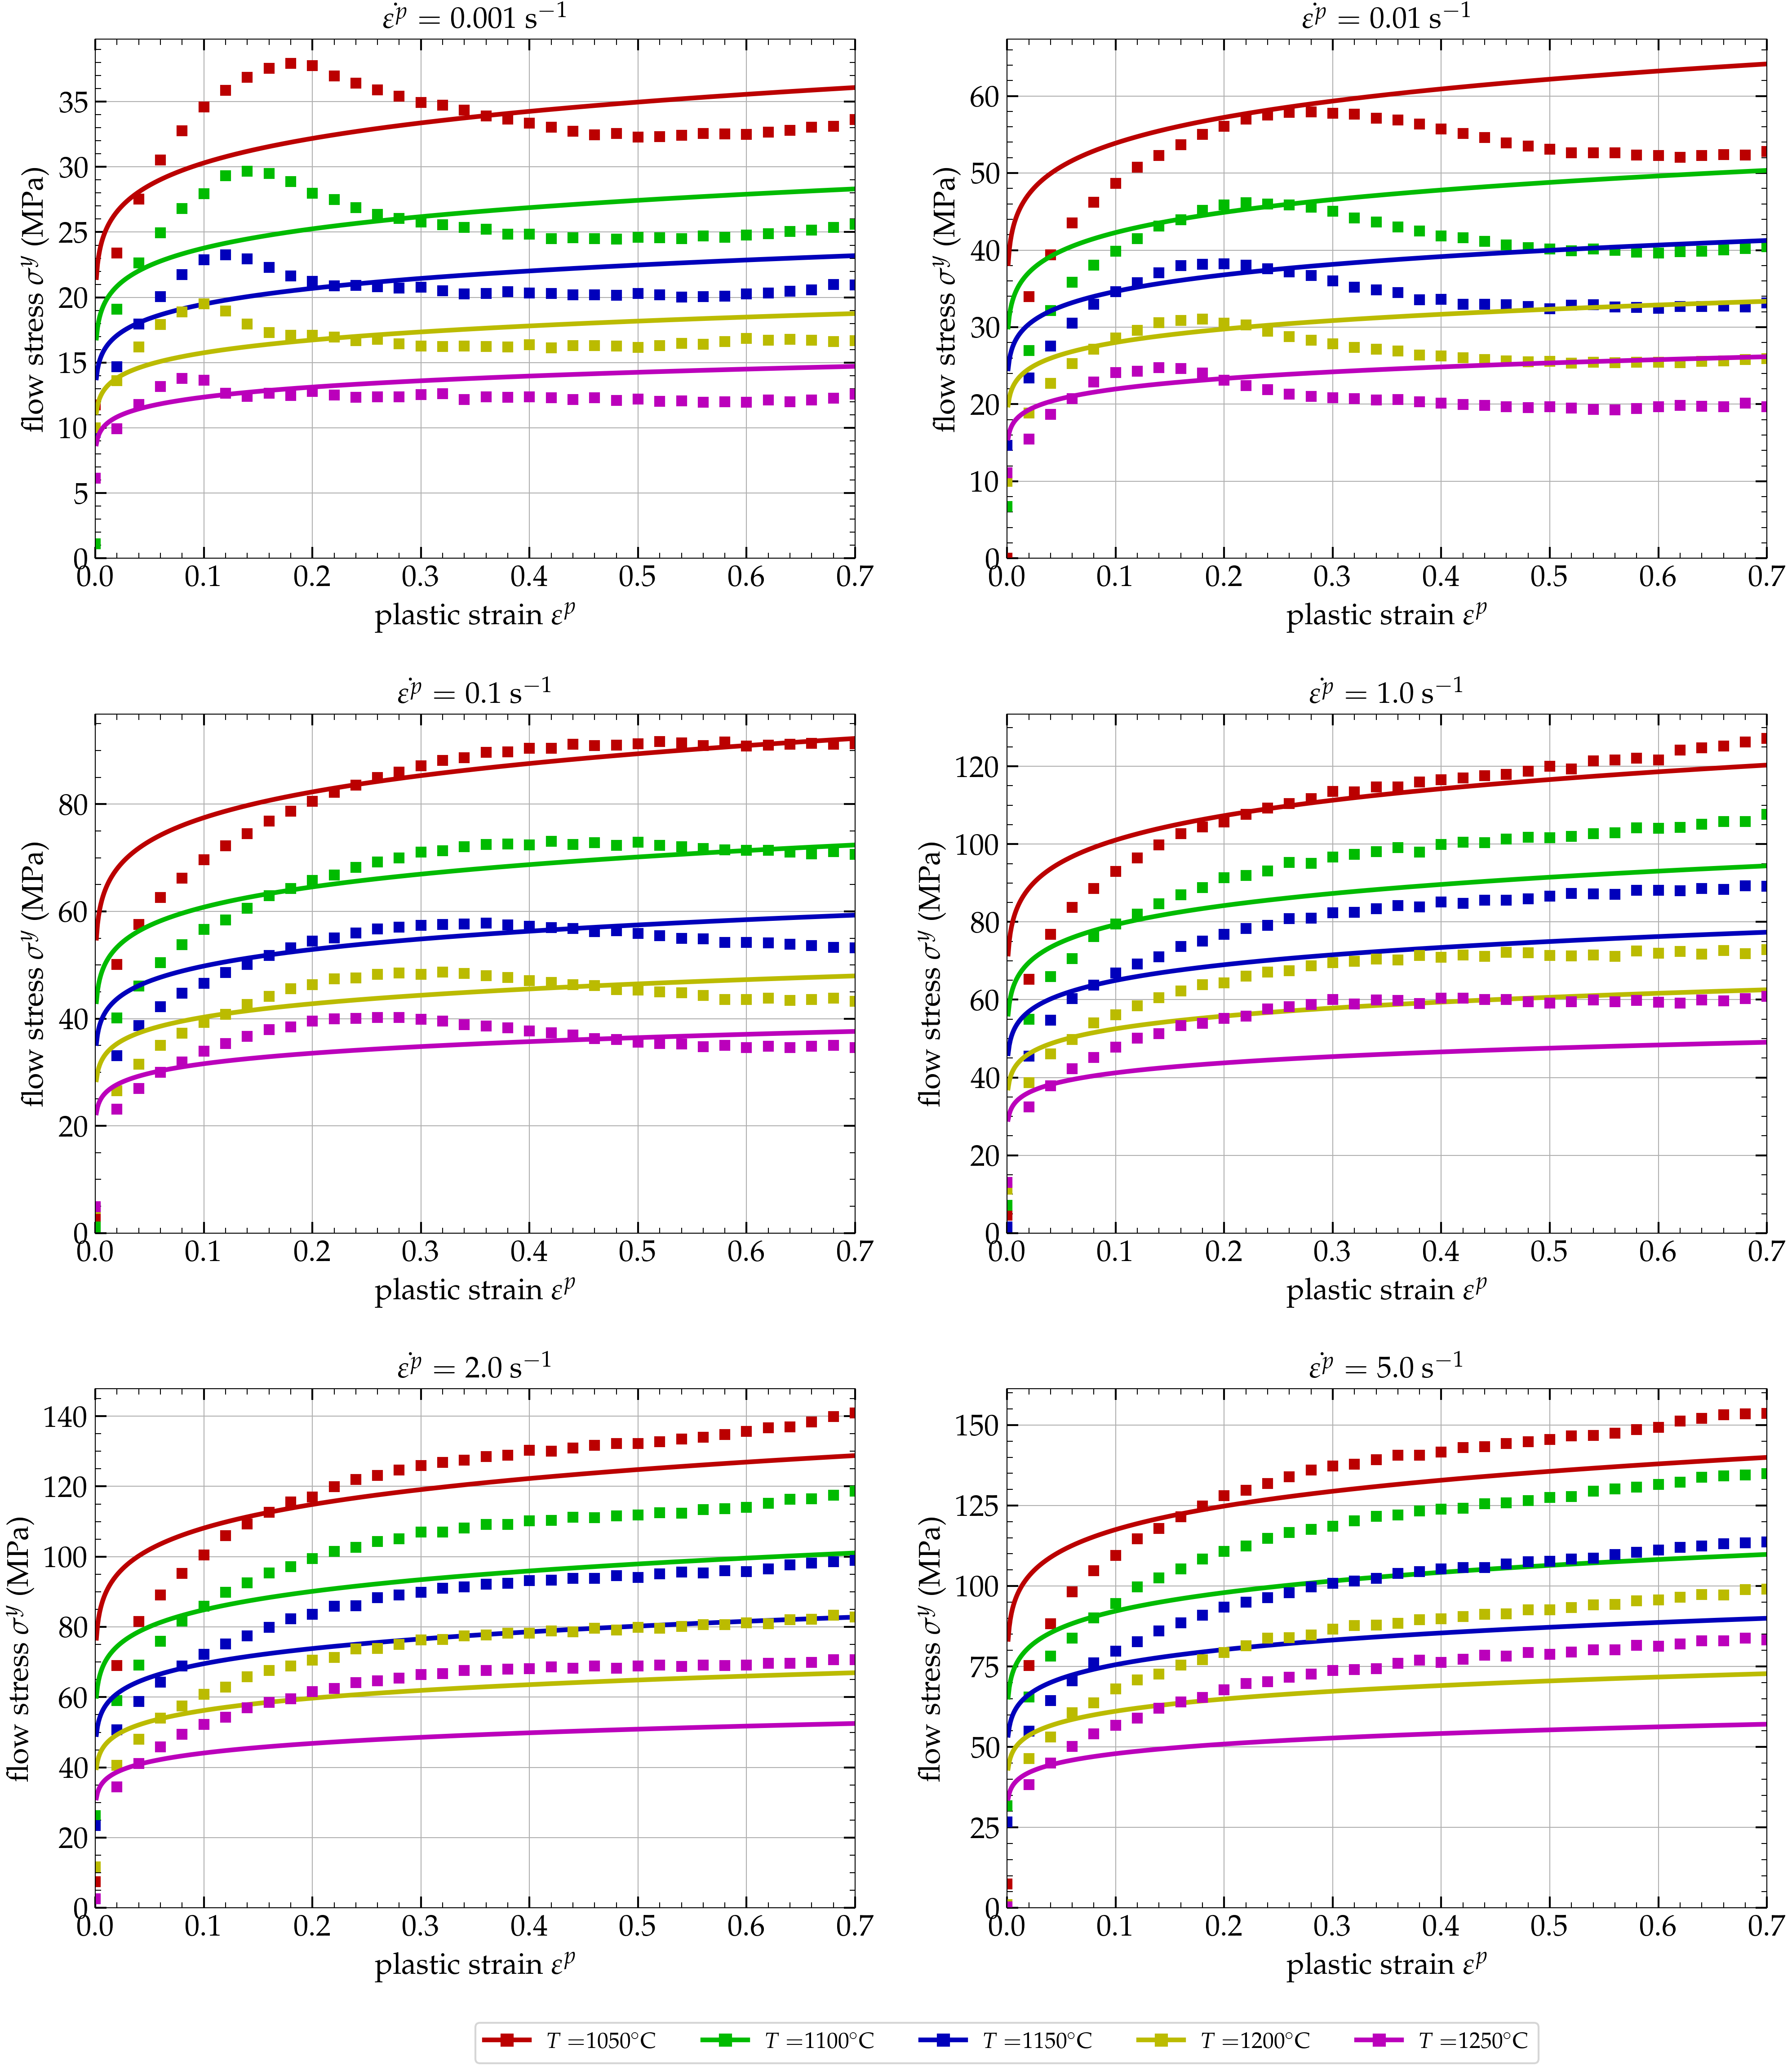

In [17]:
# Plot the curves
from matplotlib.lines import Line2D
def create_dummy_line(**kwds):
    return Line2D([], [], **kwds)

plt.figure(figsize = sbPlotSize(nEpsp))
plt.rc('text', usetex = True)
idx = 1
plt.subplots_adjust(hspace = 0.3)
for epsp in list(epsps):
    xs, ys = sbPlot(nEpsp)
    plt.subplot(xs, ys, idx)
    sbdata = shortData[shortData[:,1]==epsp]
    cl =0
    for temp in list(temperatures):
        sbdata1 = sbdata[sbdata[:,2]==temp]
        plt.plot(sbdata1[:,0], sbdata1[:,3], colors[cl], marker = 's', markersize = 5, linestyle = 'none')
        plt.plot(strains, JCconstitutiveLaw(strains, epsp, temp), colors[cl], linewidth = 2.5)
        plt.rcParams['xtick.labelsize'] = 16
        plt.rcParams['ytick.labelsize'] = 16
        cl +=1
    plt.xlim(0, 0.7)
    plt.ylim(bottom=0)
    plt.xlabel(r'plastic strain $\varepsilon^p$', fontsize = 16) # Labels the x axis
    plt.ylabel(r'flow stress $\sigma^y$ (MPa)', fontsize = 16) # Labels the y axis
    plt.title(r'$\dot{\varepsilon^p} = ' + str(epsp) + '$ s$^{-1}$', fontsize = 16) # Self explicit command
    idx += 1
    
legendLines = []
cl = 0
for temp in list(temperatures):
    legendLines.append((r'$T=$' + str(int(temp)) + r'$^{\circ}$C', {'color':colors[cl], 'linestyle':'-', 'linewidth':2.5, 'marker':'s'}))
    cl += 1

plt.legend([create_dummy_line(**l[1]) for l in legendLines],[l[0] for l in legendLines], 
           loc = 'upper center', fontsize = 12, ncols = 5, bbox_to_anchor = (0.0, -0.2), shadow = False)

plt.savefig("CompExpJC.svg")
plt.show()

In [18]:
JCstress = JCconstitutiveLaw(identData[:,0], identData[:,1], identData[:,2])

In [19]:
EAAR = np.sum(np.abs((identData[:,3] - JCstress)/(identData[:,3])))*100/JCstress.shape[0]
print("EAAR = %g" %(EAAR) + ' %')

EAAR = 13.0069 %


In [20]:
RMSE = np.sqrt(np.sum((identData[:,3] - JCstress)**2)/JCstress.shape[0])
print('RMSE = %g' %(RMSE)+' MPa')

RMSE = 10.3014 MPa
